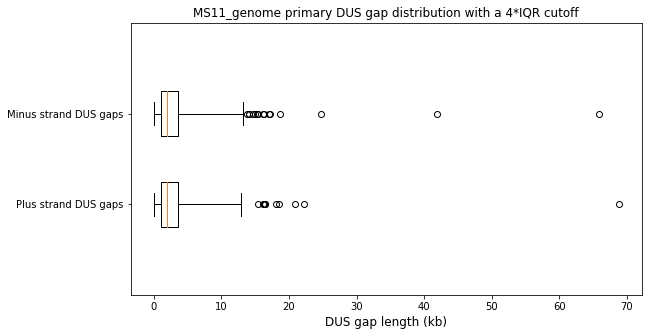

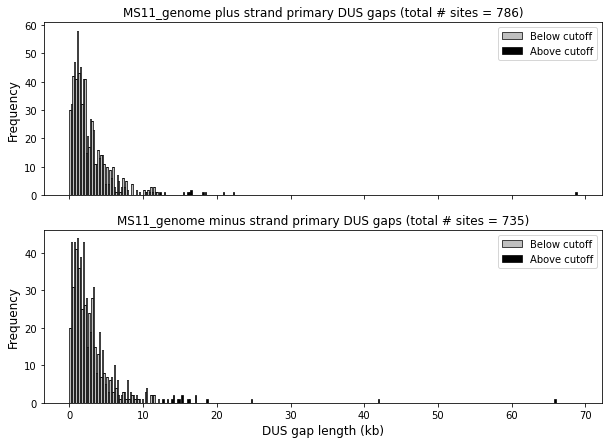

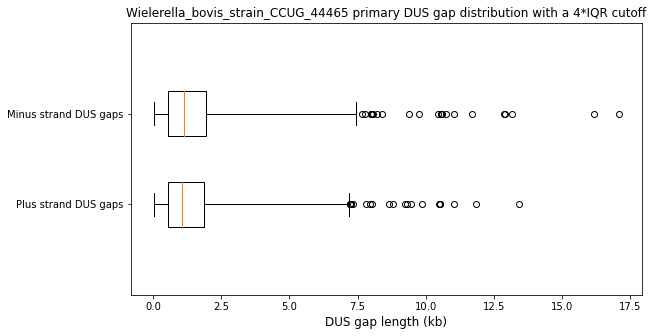

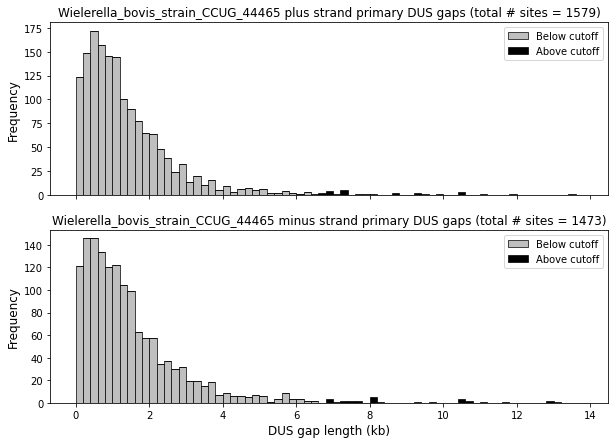

In [4]:
#DUSmapper – Alex Hughes-Games
#Described in Hughes-Games et al., Microbial Genomics 2020;6 DOI 10.1099/mgen.0.000372
#Please cite this paper if you use the script in your publications.

#This script takes a directory containing single entry Genbank sequence files as input.
#All ocurrences of the specified DUS dialect sequences (allowances for nucleotide mismatches are optional) are identified and
#added into the Genbank file as annotations. The most prevalent DUS dialect type (prDUS, which is presumably the native, endogenous
#DUS targeted by ComP of this species) is identified, and regions of the genome containing a low density of prDUS ('DUS islands')
#are also annotated. The current method for desgnating DUS islands is very basic – only the gaps between directly adjacent DUS on
#each strand are calculated, rather than the true local DUS density for a windowed region. DUS gaps which are greater than the
#median gap spacing + 4*IQR are classified as DUS islands, but this cutoff was chosen empirically by comparison with
#previously characterised Neisseria genomic islands, rather than by rigorous statistics.
#I plan to implement a better method for identifying DUS islands in future.

#In addition to annotating DUS dialects and prDUS islands, the script enables visualision of the resulting annotated genome
#with DNAplotter (https://www.sanger.ac.uk/tool/dnaplotter/) by outputting a template file (specifying the number of tracks
#and their colours etc.) and a shell script for opening the annotated genome file in DNAPlotter. DNAPlotter is Java-based, and
#your Java location may need to be added to the system path.
#In order to generate the DUSPlotter template file and shell launcher script, the path to your blank template file
#and path to your DNAPlotter application .jar file must be provided and fed into the custom_DNAPlotter_template() function.
#You may prefer to visualise DUSs and DUS islands in the annotated genome file using different software.

#Several plots of prDUS gap distributions are also saved, as well as .csv files listing counts for each DUS dialect and some prDUS
#gap statistics.

#Despite a few bells and whistles, at its heart this script just searches for DUS motifs within a genome sequence file
#(using the EMBOSS tool fuzznuc), detects prDUS islands, and annotates the sequence file with these features.

from Bio.Emboss.Applications import FuzznucCommandline
from Bio import SeqIO
import os
from os.path import basename, splitext, join
import glob
from shutil import copyfile
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#List of the eight Neisseriaceae DUS consensus sequences described in https://doi.org/10.1371/journal.pgen.1003458
#This list can be customised, but other parts of the script will need to be updated, e.g. the DNAPlotter template file.
DUSs = [['AT-DUS','ATGCCGTCTGAA'],['AG-DUS', 'AGGCCGTCTGAA'],['AG-kingDUS', 'AGGCAGCCTGAA'],
        ['AG-mucDUS', 'AGGTCGTCTGAA'],['AG-simDUS', 'AGGCTGCCTGAA'],
        ['AG-eikDUS', 'AGGCTACCTGAA'],['AA-king3DUS', 'AAGCAGCCTGCA'],
        ['TG-wadDUS', 'TGCCTGTCTGAA']]


def fuzznuc_search (genomefile, pattern, out_path):
    #Set fuzznuc parameters (more info at http://emboss.toulouse.inra.fr/cgi-bin/emboss/help/fuzznuc):
    fuzz = FuzznucCommandline()
    fuzz.sequence = genomefile
    fuzz.complement = True
    fuzz.pattern = pattern
    fuzz.pmismatch = 0
    fuzz.rformat = 'genbank' #saving to genbank format makes it straightforward to paste annotations into the genome .gb file
    outfile_gb = join(outdir, DUS[0]+'_fuzz_temp.gbk')
    fuzz.outfile = outfile_gb
    #print(fuzz) #to check that the correct commands are being fed to fuzznuc
    std_out, err_output = fuzz()
    
    #also output tsv table of DUS matches, which is easier for calculating DUS totals, spacing etc:
    fuzz.rformat = 'excel'
    fuzz.outfile = fuzz_out_tsv
    std_out, err_output = fuzz()

    #The default annotations in fuzznuc genbank output files are quite verbose, so we edit these to be more concise 
    #and include the DUS dialect as a 'gene' qualifier. This will make annotated genomes more readable in e.g. SnapGene:
    with open(outfile_gb, 'r') as fuzz_results, open(fuzz_out_gb, 'w') as w:
        for line in fuzz_results:
            if not 'nucleotide_motif' in line:
                line = line.replace('*pat pattern:'+DUS[1], DUS[0])
                w.write(line)
            else:
                #add gene field so DUS type is displayed in Artemis
                line = line.replace('/note=\"*Type SO:0000714 nucleotide_motif\"', '/gene=\"'+DUS[0]+'\"')
                w.write(line)

    os.remove(outfile_gb) #delete original verbose fuzznuc output file

    
def annotate_DUS (genomefile, fuzz_file):
    #some fuzznuc output files will be empty if no matches were found – we skip these files:
    if os.stat(fuzz_file).st_size != 0:
        temp_out = join(outdir, genome_base+'_DUS_annotated_temp.gb')
        with open(genomefile, 'r') as genome, open(temp_out, 'w') as w:
            for line in genome:
                #remove any plasmids from multi-record genbank files by breaking at the // line
                #in rare cases the plasmid sequence precedes the gDNA, so this method doesn't work
                if '//\n' not in line:
                    if not 'Location/Qualifiers' in line:
                        w.write(line)
                    else:
                        DUS_file = open(fuzz_file, 'r')
                        DUS_features = ''.join(l for l in DUS_file.readlines())
                        line = DUS_features
                        w.write(line)
                else:
                    w.write(line)
                    break #breaking at the // means that only the 1st entry is written for multi-entry .gb files.

        os.rename(temp_out, genomefile)
    os.remove(fuzz_file)
    
    
def annotate_DUS_islands(genomefile, fuzz_tsv_file, cutoff_IQR_mult):
    #identify most frequent DUS and write DUS counts
    primaryDUS, prDUS_count = max(counts, key=lambda x: x[1])
    counts.append(['Primary DUS', primaryDUS])
    counts.append(['Primary DUS mean frequency (bp/DUS)', seq_len/prDUS_count])
    
    #extract digits from primary DUS tsv output and calculate DUS site spacings
    with open(join(outdir, primaryDUS+'_fuzz_out.tsv'), 'r') as fuzz_tsv:
            for line in fuzz_tsv:
                if '+' in line:
                    plus_sites.append([int(s) for s in line.split() if s.isdigit()][0])  #the 0th element taken here is the bp START position of each prDUS
                elif '-' in line:
                    minus_sites.append([int(s) for s in line.split() if s.isdigit()][0])

            fuzz_tsv.close()

    for DUS in DUSs:
        os.remove(join(outdir, DUS[0]+'_fuzz_out.tsv'))
    
    global total_plus, total_minus
    total_plus = len(plus_sites)
    total_minus = len(minus_sites)
    counts.append(['Primary DUS +', total_plus])
    counts.append(['Primary DUS -', total_minus])
                   
    plus_gaps = [a-b for a, b in zip(plus_sites[1:], plus_sites)]
    minus_gaps = [a-b for a, b in zip(minus_sites[1:], minus_sites)]
    global plus_gaps_kb, minus_gaps_kb
    plus_gaps_kb = [float(i)/1000 for i in plus_gaps]
    minus_gaps_kb = [float(i)/1000 for i in minus_gaps]

    #setting gap length cutoff
    plus_median = np.median(plus_gaps)
    minus_median = np.median(minus_gaps)
    p_q75, p_q25 = np.percentile(plus_gaps, [75 ,25])
    m_q75, m_q25 = np.percentile(minus_gaps, [75 ,25])
    plus_iqr = p_q75 - p_q25
    minus_iqr = m_q75 - m_q25
    plus_cutoff = plus_median + (cutoff_IQR_mult * plus_iqr)
    minus_cutoff = minus_median + (cutoff_IQR_mult * minus_iqr)
    counts.append(['Gap median plus', plus_median])
    counts.append(['Gap median minus', minus_median])
    counts.append(['Gap IQR plus', plus_iqr])
    counts.append(['Gap IQR minus', minus_iqr])

    # iterate through plus/minus_sites and append bp position pair to new list if distance to next element exceeds gap threshold
    for i in range(len(plus_gaps)):
        if plus_gaps[i] > plus_cutoff:
            DUSislands_plus.append([plus_sites[i], plus_sites[i+1], plus_sites[i+1] - plus_sites[i]])
        else:
            smaller_gaps_plus.append([plus_sites[i], plus_sites[i+1], plus_sites[i+1] - plus_sites[i]])
    
    for i in range(len(minus_gaps)):
        if minus_gaps[i] > minus_cutoff:
            DUSislands_minus.append([minus_sites[i], minus_sites[i+1], minus_sites[i+1] - minus_sites[i]])
        else:
            smaller_gaps_minus.append([minus_sites[i], minus_sites[i+1], minus_sites[i+1] - minus_sites[i]])
    
    counts.append(['Primary DUS islands + :','',''])
    counts.append(['Start', 'End', 'Length'])
    for i in DUSislands_plus:
        counts.append([i[0], i[1], i[2]])

    counts.append(['Primary DUS islands - :','',''])
    counts.append(['Start', 'End', 'Length'])
    for i in DUSislands_minus:
        counts.append([i[0], i[1], i[2]])

    #annotate DUS islands
    with open(genomefile, 'r') as genome, open(genome_final, 'w') as w:
        for line in genome:
            if not 'Location/Qualifiers' in line:
                w.write(line)
            else:
                w.write(line)
                for i in DUSislands_plus:
                    line = '     misc_feature    '+str(i[0])+'..'+str(i[1])+'\n                     /gene="DUS_island_plus"\n                     /note="DUS_island_plus"\n'
                    w.write(line)
                for i in DUSislands_minus:
                    line = '     misc_feature    complement('+str(i[0])+'..'+str(i[1])+')\n                     /gene="DUS_island_minus"\n                     /note="DUS_island_minus"\n'
                    w.write(line)

    with open(join(outdir,'DUS_stats.csv'), 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(counts)

    csvFile.close()
    os.remove(genomefile)    #delete file containing only DUS annotations but not islands.

def plot_gap_distributions():
        #convert gap values to kb for plotting:
        DUSislands_plus_kb = [float(i[2])/1000 for i in DUSislands_plus]
        DUSislands_minus_kb = [float(i[2])/1000 for i in DUSislands_minus]
        small_plus_gaps_kb = [float(i[2])/1000 for i in smaller_gaps_plus]
        small_minus_gaps_kb = [float(i[2])/1000 for i in smaller_gaps_minus]
        plus_gaps_kb = DUSislands_plus_kb + small_plus_gaps_kb
        minus_gaps_kb = DUSislands_minus_kb + small_minus_gaps_kb
        
        fontsize = 12
        #boxplot
        plt.figure(figsize=(10, 5))
        plt.subplots_adjust(left=0.19) #prevents label clipping
        plt.title(genome_base+' primary DUS gap distribution with a '+str(cutoff_mult)+'*IQR cutoff')
        plt.xlabel('DUS gap length (kb)', fontsize=fontsize)
        #use cutoff_IQR_mult * IQR as whisker length.
        plt.boxplot([plus_gaps_kb, minus_gaps_kb], 
                    widths=0.25, 
                    vert=False, 
                    whis=cutoff_mult, 
                    positions=[0.5,1], 
                    labels = ['Plus strand DUS gaps','Minus strand DUS gaps'], 
                    sym='o')
        plt.savefig(join(outdir, 'DUS_gaps_boxplot.pdf'))
        plt.show()
        
        #plot histograms
        f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 7))
        ax1.hist([small_plus_gaps_kb, DUSislands_plus_kb], 
                 color=['0.75', 'black'], 
                 linewidth=0.7, 
                 rwidth=1, 
                 bins=np.arange(0.0, np.ceil(max(DUSislands_plus_kb)), 0.2), 
                 stacked=True, 
                 label = ['Below cutoff','Above cutoff'], 
                 edgecolor='black')
        ax1.set_ylabel('Frequency', fontsize=fontsize);
        ax1.legend()
        ax1.set_title(genome_base+' plus strand primary DUS gaps (total # sites = '+str(total_plus)+')')

        ax2.hist([small_minus_gaps_kb, DUSislands_minus_kb],
                 color=['0.75', 'black'], 
                 linewidth=0.7, 
                 rwidth=1, 
                 bins=np.arange(0.0, np.ceil(max(DUSislands_plus_kb)), 0.2), 
                 stacked=True, 
                 label = ['Below cutoff','Above cutoff'], 
                 edgecolor='black')
        ax2.set_ylabel('Frequency', fontsize=fontsize);
        ax2.set_xlabel('DUS gap length (kb)', fontsize=fontsize)
        ax2.legend()
        ax2.set_title(genome_base+' minus strand primary DUS gaps (total # sites = '+str(total_minus)+')')
        plt.savefig(join(outdir, 'Gap histograms.pdf'))
        plt.show()
    
def custom_DNAPlotter_template(blank_template_path, app_path):
        #create customised DNAPlotter template file:
        template_edit = join(outdir, genome_base+'8DUStemplate')

        with open (blank_template_path, 'r') as r, open(template_edit,'w') as w:
            for line in r:
                if 'end=' in line:
                    line = line.replace('for_replacement', str(seq_len))
                    w.write(line)
                elif not 'temp_genome.gb' in line:
                    w.write(line)
                else:
                    line = line.replace('temp_genome.gb', basename(genome_final))
                    line = line.replace('/temp/path/', os.path.abspath(outdir))
                    w.write(line)

        script_out = join(outdir, genome_base+'plot.command')
        with open(script_out,'w') as w:
            w.write('#!/bin/bash\n#Java may need to be added to the system path for this launch script to work.\njava -jar '+app_path+' -t ' + template_edit)

        #make bash script executable - '.command' extension is required for this
        os.system('chmod 755 '+os.path.abspath(script_out))
    
#------------------------------------------------------------------------------------------------------------    
    
#REPLACE THE FOLLOWING WITH PATH TO DIRECTORY CONTAINING COMPLETE (SINGLE ENTRY) GENBANK GENOME SEQUENCES:
dir_path = '/path/to/directory/containing/genomes'   #NB you must ensure there are no blank spaces in the path to this directory.

#REPLACE WITH PATH TO BLANK DNAPLOTTER TEMPLATE:
plotter_template = "/path/to/DNAPlotter/template"   #NB you must ensure there are no blank spaces in the file name.

#REPLACE WITH PATH TO DNAPLOTTER APPLICATION .jar FILE:
DNAPlotter_path = "/path/to/DNAPlotter/application"     

    #loop over each genbank genome file in the directory:
for filename in glob.glob(join(dir_path, '*.gb*')):
    genomefile = filename
    genome_base = splitext(basename(genomefile))[0]
    outdir = join(dir_path, genome_base+'_DUSmapper_output')
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    counts = []     #initialise list to contain DUS counts and gap stats (which will be saved to a .csv)
    
    #loop the fuzznuc search over each DUS dialect:
    for i, DUS in enumerate(DUSs):
        fuzz_out_gb = join(outdir, DUS[0]+'_fuzz_out.gbk')   #name the fuzznuc genbank output file
        fuzz_out_tsv = join(outdir, DUS[0]+'_fuzz_out.tsv')
        fuzznuc_search(genomefile=genomefile, pattern=DUS[1], out_path=outdir)
        
        #copy the original genome file and annotate the DUS sequence matches: 
        genome_copy = join(outdir, genome_base+'_DUS_annotated.gb')
        if i==0:     
            copyfile(genomefile, genome_copy)
        
        annotate_DUS(genomefile=genome_copy, fuzz_file=fuzz_out_gb)
        
        #count DUSs from tsv file lines (subtract 1 to exclude the header line). Manually add 0 for no DUS cases
        num_lines = sum(1 for line in open(fuzz_out_tsv))
        if num_lines == 0:
            counts.append([DUS[0],0])      
        else:
            counts.append([DUS[0], num_lines-1])
    
    genome_final = join(outdir, genome_base+'_DUS_mapped.gb') #the final genome file with annotated DUSs and DUS islands.
    plus_sites, minus_sites = [], []                   #initialise lists to contain genomic positions of all DUSs.
    DUSislands_plus, DUSislands_minus = [], []         #initialise lists to contain the start/end positions and length of all DUS islands. 
    smaller_gaps_plus, smaller_gaps_minus = [], []     #initialise lists to contain the start/end positions and length of all gaps < cutoff.      
    
    seq_orig = SeqIO.read(genomefile,'genbank')
    seq_len = len(seq_orig)
    cutoff_mult = 4   #set the multiplier determining how many IQRs from the median a DUS gap must be before being considered an island.
    annotate_DUS_islands(genomefile=genome_copy, fuzz_tsv_file=fuzz_out_tsv, cutoff_IQR_mult=cutoff_mult)
    
    plot_gap_distributions() 

    custom_DNAPlotter_template(blank_template_path = plotter_template, app_path=DNAPlotter_path)
